In [1]:
import pandas as pd
import s3_modules
import tccstorage as stor
stor.change_tcc_aws_env('production')
import geopandas as gpd
from tccutils.geo.vector import get_epsg_code_from_lon_lat
from tccutils.geo.conversions import lonlat_to_utm
import numpy as np
from shapely.geometry import shape
# from shapely.wkt import loads
import shapely.wkt
# import shapely
import random
import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
import math
import json
from tccservices.blizzard_wrapper import request_blizzard_data
from datetime import datetime
from datetime import timedelta
import matplotlib.dates as mdates


INFO:io_utils.env_utils:Changing environment to production


In [2]:
script_ids = pd.read_csv('data/growers_reports/input_data/script_ids.csv')

#================================================================================================
#Input PRICES
Pc = 3.85 #$/bu https://dtn.ilfb.org/index.cfm?show=31&mid=5
Pn = 400/(2240*0.46) #$/lb N https://www.ams.usda.gov/mnreports/gx_gr210.txt

#================================================================================================  

In [3]:
def make_script_gdf(script_json: dict) -> gpd.GeoDataFrame:
    geometries = []
    zone_class = []
    reps_seq = []

    for features in script_json['plot-geometries']:
        try:
            feature_static = features['single-rate-plot']
            geometries.append(shape(feature_static))
            zone_class.append('static_rate_zone')
            reps_seq.append(features['rep-id'])

            feature_vr = features['no-change-plot']
            geometries.append(shape(feature_vr))
            zone_class.append('vr_rate_zone')
            reps_seq.append(features['rep-id'])
        except Exception as e:
            print(e)

    script_gdf = gpd.GeoDataFrame({
            'geometry': geometries,
            'zone_class': zone_class,
            'rep': reps_seq
        })
    script_gdf = script_gdf.explode()
    script_gdf = script_gdf.reset_index()#.rename(columns={0: 'geometry'})
    script_gdf = script_gdf.drop(['level_0', 'level_1'], axis=1)

    epsg_code = get_epsg_code_from_lon_lat(script_gdf.centroid[1].x, script_gdf.centroid[1].y)
    script_gdf.crs = {'init' :'epsg:4326'}
    new_crs = {'init' : 'epsg:' + epsg_code}
    script_utm_gdf = script_gdf.to_crs(new_crs)
    script_gdf["area_m2"] = script_utm_gdf['geometry'].area
    return script_gdf

In [4]:
def make_n_app_gdf(n_app_data:pd.DataFrame, script_gdf:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    n_app_gdf = gpd.GeoDataFrame({
        'geometry': [shapely.wkt.loads(feature) for feature in n_app_data['polygon']],
        'n_rate_lb_per_acre': n_app_data['application_rate_lbs_n_per_acre']
    })

    n_app_gdf = n_app_gdf.explode()
    n_app_gdf = n_app_gdf.reset_index()#.rename(columns={0: 'geometry'})
    n_app_gdf = n_app_gdf.drop(['level_0', 'level_1'], axis=1)
    epsg_code = get_epsg_code_from_lon_lat(n_app_gdf.centroid[1].x, n_app_gdf.centroid[1].y)
    n_app_gdf.crs = {'init' :'epsg:4326'}
    new_crs = {'init' : 'epsg:' + epsg_code}
    n_app_utm_gdf = n_app_gdf.to_crs(new_crs)
    n_app_gdf["area_m2"] = n_app_utm_gdf['geometry'].area
    
    # "clip" a n_app_gdf layer to the boundary of a script_gdf
    poly = script_gdf.geometry.unary_union
    n_app_gdf = n_app_gdf[n_app_gdf.geometry.intersects(poly)]
    
    return(n_app_gdf)

In [5]:
def make_yaf_gdf(yaf_data:pd.DataFrame, script_gdf:gpd.GeoDataFrame) -> gpd.GeoDataFrame: 
    #To use when get real data from farmers
    yaf_gdf = gpd.GeoDataFrame({
            'geometry': [shapely.wkt.loads(feature) for feature in yaf_data['combine_geometry']],
             'yield_bu_acre': yaf_data['corrected_dry_yield_bu_acre']
        })

    yaf_gdf = yaf_gdf.explode()
    yaf_gdf = yaf_gdf.reset_index()#.rename(columns={0: 'geometry'})
    yaf_gdf = yaf_gdf.drop(['level_0', 'level_1'], axis=1)
    
    #Transform to utm to get the area
    epsg_code = get_epsg_code_from_lon_lat(yaf_gdf.centroid[1].x, yaf_gdf.centroid[1].y)
    yaf_gdf.crs = {'init' :'epsg:4326'}
    new_crs = {'init' : 'epsg:' + epsg_code}
    yaf_utm_gdf = yaf_gdf.to_crs(new_crs)
    yaf_gdf["area_m2"] = yaf_utm_gdf['geometry'].area
    
    # "clip" a yaf_gdf layer to the boundary of a script_gdf
    poly = script_gdf.geometry.unary_union
    yaf_gdf = yaf_gdf[yaf_gdf.geometry.intersects(poly)]
    
    return(yaf_gdf)

In [6]:
def make_fake_yaf_gdf(n_app_gdf):
    #To use until we get the 2019 data
    yaf_gdf = n_app_gdf.copy(deep=True) 
    yaf_gdf['yield_bu_acre'] = yaf_gdf['n_rate_lb_per_acre']
    yaf_gdf = yaf_gdf.drop(['n_rate_lb_per_acre'], axis=1)

    y_median = int(yaf_gdf['yield_bu_acre'].median())+15
    y_min = 40

    my_randoms = [random.randrange(-10, 5, 1) if x<y_median else 
                  random.randrange(-40, 0, 1) for x in yaf_gdf['yield_bu_acre']]

    yaf_gdf['yield_bu_acre'] = yaf_gdf['yield_bu_acre'] + my_randoms 
    yaf_gdf.loc[yaf_gdf['yield_bu_acre'] < y_min, 'yield_bu_acre'] = random.randrange(40, 50, 1)

    return(yaf_gdf)

In [7]:
def make_n_app_map(n_app_gdf:gpd.GeoDataFrame):
    #n_app_gdf.loc[n_app_gdf['n_rate_lb_per_acre'] > 350, 'n_rate_lb_per_acre'] = 350
    #================================================================================================
    # PLOT THE AS-APP
    fig, ax = plt.subplots(1,1)
    divider = make_axes_locatable(ax)

    cax = divider.append_axes("right", size="5%", pad=0.1)

    cax.text(0.5, 0.5, 'N lb/ac', horizontalalignment='center',
             verticalalignment='center', transform=cax.transAxes, 
             rotation = 90, fontsize = 12)

    cmap = "Blues"

    n_app_gdf.plot('n_rate_lb_per_acre', ax=ax, cmap=cmap, legend = True, cax = cax)


    #Add borders of grower_rate area
    zones_gdf = script_gdf.dissolve(by='zone_class')
    # zones_gdf.plot(ax=ax, color='white', edgecolor='black')
    zones_gdf.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax)
    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

    plot_file_name = "data/growers_reports/figures/"+field_id_n['field_id']+"_asapp_map.png"

    plt.savefig(plot_file_name, dpi=300, bbox_inches="tight", pad_inches=0.1)

In [8]:
def make_yield_map(yaf_gdf:gpd.GeoDataFrame):
    # MAKE THE PLOT
    fig, ax = plt.subplots(1,1)
    divider = make_axes_locatable(ax)

    cax = divider.append_axes("right", size="5%", pad=0.1)

    cax.text(0.5, 0.5, 'Yield bu/ac', horizontalalignment='center',
             verticalalignment='center', transform=cax.transAxes, 
             rotation = 90, fontsize = 12)

    cmap = "RdYlGn"
    # cmap = "Blues"
    yaf_gdf.plot('yield_bu_acre', ax=ax, cmap=cmap, legend = True, cax = cax)

    zones_gdf = script_gdf.dissolve(by='zone_class')

    #Add borders of grower_rate area
    zones_gdf.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 1,ax=ax)

    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    ax.set_xticks([])
    ax.set_yticks([])

    plt.tight_layout()

    plot_file_name = "data/growers_reports/figures/"+field_id_n['field_id']+"_yield_map.png"
    plt.savefig(plot_file_name, dpi=300, bbox_inches="tight", pad_inches=0.1)
    return(yaf_gdf)

In [9]:
# DO PROFITS CALCULATIONS
def aggregate_data(script_gdf, n_app_gdf, yaf_gdf, Pc, Pn):
    script_gdf['zone_id'] = list(range(1, len(script_gdf)+1))
    #================================================================================================
    #JOIN THE SCRIPT DATA WITH THE N_APP DATA
    #First transforms n_app data to points, join with the cells of the script and get median value
    n_app_gdf.geometry = n_app_gdf.geometry.apply(lambda s: s.centroid)
    joined_gdf = gpd.sjoin(script_gdf, n_app_gdf[['geometry', 'n_rate_lb_per_acre']], op='contains')

    #Get the median for each zone_id
    n_median = joined_gdf.groupby('zone_id').agg({'n_rate_lb_per_acre':np.median})
    all_gdf = script_gdf.merge(n_median, on='zone_id')
    #================================================================================================
    #JOIN THE SCRIPT DATA WITH THE YIELD DATA
    yaf_gdf.geometry = yaf_gdf.geometry.apply(lambda s: s.centroid)
    joined_gdf = gpd.sjoin(script_gdf, yaf_gdf[['geometry', 'yield_bu_acre']], op='contains')

    #Get the median for each zone_id
    yield_median = joined_gdf.groupby('zone_id').agg({'yield_bu_acre':np.median})
    all_gdf = all_gdf.merge(yield_median, on='zone_id')
    # #================================================================================================
    # #Do some calculations: get the profits and the area in ac. Need to have the profits in the gdf for the map
    all_gdf['p_dol_ac'] = all_gdf['yield_bu_acre'] * Pc - all_gdf['n_rate_lb_per_acre'] * Pn
    all_gdf['area_ac'] = all_gdf['area_m2']/4046.86
    # #================================================================================================
    # # SUMMARIZE BY GROWER VS VR ZONE
    # #================================================================================================
    # #GET GROSS FOR EACH CELL (IS THE TOTAL AMOUNT OF GRAIN AND N THAT YIELD WILL PROVIDE)
    all_df = pd.DataFrame(all_gdf.drop(columns='geometry'))
    all_df['p_gross'] = all_df['p_dol_ac']*all_df['area_ac']
    all_df['n_gross'] = all_df['n_rate_lb_per_acre']*all_df['area_ac']
    all_df['yield_gross'] = all_df['yield_bu_acre']*all_df['area_ac']

    #================================================================================================
    # Group the data
    grouped = all_df.groupby('zone_class')

    summary = grouped.agg({ 'yield_gross' : 'sum',
                            'n_gross' : 'sum',
                            'p_gross': 'sum', 
                            'area_ac': 'sum'})

    summary['yield_bu_ac'] = summary['yield_gross']/summary['area_ac']
    summary['n_asapplied'] = summary['n_gross']/summary['area_ac']
    summary['p_dol_ac'] = summary['p_gross']/summary['area_ac']
    summary['p_dol_ac_CHECK'] = (summary['yield_gross'] * Pc - summary['n_gross'] * Pn)/summary['area_ac']
    
    return(summary)


In [10]:
#MAKE A VERTICAL PROFITS BAR CHART (ONE RATE VS THE OTHER)
def make_profits_bar(summary):
    avg_yield = round((summary['p_dol_ac']).mean(),1)

    prod1 = 'vr_rate_zone'
    prod1_yield = round(summary.loc[prod1, 'p_dol_ac'], 1)

    prod2 = 'static_rate_zone'
    prod2_yield = round(summary.loc[prod2, 'p_dol_ac'], 1)
    yields = [prod2_yield, prod1_yield]
    prods = [prod2, prod1]

    fig = plt.figure(figsize=(4.0, 4.0))

    ax1 = fig.add_subplot(111)

    pos = np.arange(2) + 0.5

    lsd_error = [5,10]

    y_min = math.floor(min(yields)/25)*25 -8
    y_max = math.ceil(max(yields)/25)*25

    rects = ax1.bar(pos, yields, width=0.8, align='center', color=['red', 'lightgreen'])

    # plt.errorbar(pos, yields, yerr=lsd_error, fmt='.', markersize=0, capsize=20, color = 'black')

    position = np.round(avg_yield, decimals=0)

    ax1.axis([0, 2, y_min, y_max])
    y_pos = np.arange(len(prods))

    plt.xticks(pos, ['Static', 'Variable'])
    plt.ylabel('N Profits $/ac')
    plt.xlabel('Treatment')

    count = 0
    for yld in yields:
        rect = rects[count]
        # yloc = y_max - 5  
        yloc = y_min + 5
        # yloc = yld + lsd_error[count]+2
        xloc = pos[count]  # Center the text vertically in the #bar
        ax1.text(xloc, yloc, yld, horizontalalignment='center', verticalalignment='center', size='medium', color='black', weight='normal')
        count += 1

    plt.tight_layout()
    plot_file_name = "data/growers_reports/figures/"+field_id_n['field_id']+"_profits_bar_v.png"
    plt.savefig(plot_file_name)

In [11]:
# MAKE A TABLE WITH ALL THE INFORMATION THAT WILL BE USED IN THE PDF
def save_information_to_json(field_id_n, summary):
    google_sheet = pd.read_csv("data/growers_reports/input_data/vrn_google_sheet.csv")
    google_sheet_n = google_sheet.loc[google_sheet['UUID'] == field_id_n['field_id']].iloc[0]

    general_info = dict()
    general_info['field_id'] = field_id_n['field_id']
    general_info['email'] = google_sheet_n['Email Address']
    general_info['last_name'] = google_sheet_n['Last Name']
    general_info['first_name'] = google_sheet_n['First Name']
    general_info['city'] = google_sheet_n['City']
    general_info['state'] = google_sheet_n['State']
    general_info['farm_name'] = google_sheet_n['2019 FieldView™ FARM Name']
    general_info['field_name'] = google_sheet_n['2019 FieldView™FIELD Name']
    general_info['planting_date'] = google_sheet_n['Planting Date']
    general_info['coop_name'] = google_sheet_n['Which cooperative you are working with for this study?']
    general_info['harvest_date'] = float('nan') #add harvest date to the google sheet
    general_info['product_n'] = n_app_data.iloc[1]['application_product_name']
    general_info['n_app_date'] = n_app_data.iloc[1]['date']
    general_info['planting_date2'] = n_app_data.iloc[1]['planting_date']
    general_info["summary"] = summary[['area_ac','yield_bu_ac', 'n_asapplied', 'p_dol_ac']].to_json()
    general_info["Pc"] = Pc
    general_info["Pn"] = Pn
    #Save it a json
    response_file_name = "data/growers_reports/data_table/"+field_id_n['field_id']+"_table.json"

    f = open(response_file_name,"w")
    f.write(json.dumps(general_info))
    f.close()

In [23]:
# WEATHER PLOT
# ----------------
# Download the data
def make_weather_plot(script_gdf):
    #=================================================================================================#
    #LOAD THE GENERAL INFO OF THE FIELD
    general_info_name = "data/growers_reports/data_table/"+field_id+"_table.json"

    with open(general_info_name) as json_file:  
        general_info = json.load(json_file)

    #=================================================================================================#
    single_latitude = script_gdf.centroid[1].y
    single_longitude = script_gdf.centroid[1].x
    variable = ['precipitation']
    start_date = "2010-01-01"
    end_date = "2019-12-31"

    blizzard_response = request_blizzard_data(latitudes=single_latitude,
                                              longitudes=single_longitude,
                                              variables=variable,
                                              start_date=start_date,
                                              end_date=end_date,
                                              reference_date="LATEST",
                                              n_realizations=1,
                                              environment='qa1')

    hist_precip = blizzard_response['variables']['precipitation']['data'][0][0]

    mydates = pd.date_range(start_date, end_date).tolist()

    # Create a dataframe from zipped list
    weather_df = pd.DataFrame(list(zip(mydates, hist_precip)), columns = ['date' , 'ppt']) 

    weather_df['year'] = pd.to_numeric(weather_df['date'].dt.strftime('%Y'))
    weather_df['day'] = pd.to_numeric(weather_df['date'].dt.strftime('%j'))
    weather_df['ppt'] = pd.to_numeric(weather_df['ppt'],errors='coerce')

    #--------
    #Work with the historic weather (before 2019)
    weather_hist_df = weather_df[(weather_df.year < 2019) & (weather_df.day < 366)][['day', 'ppt']]
    weather_hist_df = weather_hist_df.groupby(['day']).mean().reset_index().rename(columns={'ppt':'ppt_hist'})
    weather_hist_df['ppt_hist'] = weather_hist_df['ppt_hist'].cumsum()/25.4 #convert to inches


    #--------
    #Work with the actual weather (2019)
    weather_act_df = weather_df[weather_df.year == 2019][['day', 'ppt']].reset_index(drop = True).rename(columns={'ppt':'ppt_act'})
    weather_act_df['ppt_act'] = weather_act_df['ppt_act'].cumsum()/25.4 #convert to inches


    weather_paired_df = pd.merge(weather_hist_df, weather_act_df, on='day', how='left')
    weather_paired_df['date'] = pd.date_range('2019-01-01', '2019-12-31').tolist()

    #========================================================================
    # MAKE A PRECIPITATION GRAPH

    fig, ax = plt.subplots()
    ax.plot(weather_paired_df['date'], weather_paired_df['ppt_hist'], label = 'Historical Avg')
    ax.plot(weather_paired_df['date'], weather_paired_df['ppt_act'],  label = '2019')

    #========================================================================
    #ADD VERTICAL LINES FOR PLANTING, SIDEDRESS AND HARVESTING DATES
    max_ppt = max(weather_paired_df['ppt_hist'].append(weather_paired_df['ppt_act']))
    date = datetime.strptime(general_info['planting_date2'][0:10], '%Y-%m-%d')
    plt.axvline(x=date)
    plt.text(date+ timedelta(days=-4), 1, 'Planting', horizontalalignment='center', 
             verticalalignment='bottom', size='medium', color='black', weight='normal', rotation=90)

    date = datetime.strptime(general_info['n_app_date'], '%Y-%m-%d')
    plt.axvline(x=date)
    plt.text(date+ timedelta(days=-4), 1, 'N app', horizontalalignment='center', 
             verticalalignment='bottom', size='medium', color='black', weight='normal', rotation=90)

    if not math.isnan(general_info['harvest_date']):
        date = datetime.strptime(general_info['harvest_date'], '%Y-%m-%d')
        plt.axvline(x=date)
        plt.text(date+ timedelta(days=-4), 1, 'Harvesting', horizontalalignment='center', 
                 verticalalignment='bottom', size='medium', color='black', weight='normal', rotation=90)

    #========================================================================
    plt.xlabel("day", size = 12)
    plt.ylabel("Cumulative Precipitation (in)", size = 12)

    #Format the x axis with moths
    locator = mdates.MonthLocator()  # every month
    fmt = mdates.DateFormatter('%b')

    ax.xaxis.set_major_locator(locator)
    # Specify formatter
    ax.xaxis.set_major_formatter(fmt)

    # #Get max and minimum values for both target and asapplied
    plt.legend()
    # ax1.legend(loc='upper center', bbox_to_anchor=(1.25, 1), shadow=True, ncol=1)
    # plt.xlim(0, 365)
    ax.set_xlim(min(weather_paired_df['date']) , max(weather_paired_df['date']))
    plt.ylim(0, max(weather_paired_df['ppt_hist'].append(weather_paired_df['ppt_act']))+5)
    # plt.gca().set_aspect('equal', adjustable='box')
    plt.tight_layout()
    plot_file_name = "data/growers_reports/figures/"+field_id+"_precipitation.png"
    plt.savefig(plot_file_name, dpi=300)

In [24]:
#MAKE A VERTICAL YIELD AND NITROGEN BAR CHART (ONE RATE VS THE OTHER)
def make_yield_bar(summary):
    #----------------------------------------------------------------------
    prod1 = 'vr_rate_zone'
    prod2 = 'static_rate_zone'
    prods = [prod2, prod1]

    #----------------------------------------------------------------------
    yields = [round(summary.loc[prod2, 'yield_bu_ac'], 1), round(summary.loc[prod1, 'yield_bu_ac'], 1)]
    nrates= [round(summary.loc[prod2, 'n_asapplied'], 1), round(summary.loc[prod1, 'n_asapplied'], 1)]
    #----------------------------------------------------------------------

    fig = plt.figure(figsize=(6.0, 4.0))

    ax1 = fig.add_subplot(111)

    bar_width = 0.35
    pos = [0.5, 0.5+bar_width]

    # max_width = max(yields) + 10 + 10

    y_min = math.floor(min(yields)/25)*25
    y_max = math.ceil(max(yields)/25)*25
    # # Center bars on the Y-axis ticks
    # DOCUMENTATION:       pyplot.bar(x, height, width=0.8, bottom=None, *, align='center', data=None, **kwargs)
    # ORIGINAL CODE: rects = ax1.barh(pos, yields, height=0.7, align='center', color='lightblue')


    rects = plt.bar(pos, nrates, width=bar_width, align='center', color=['lightblue'], 
                    edgecolor = ['darkblue'],label = 'N (lb/ac)')
    #=====================================================================================================#
    pos2 = [x+1 for x in pos]
    rects2 = plt.bar(pos2, yields, width=bar_width, align='center', color=['lightgreen'], 
                     edgecolor = ['darkgreen'], label = 'Yield (bu/ac)' )

    y_pos = [0.5+bar_width/2, 1.5+bar_width/2]

    plt.xticks(y_pos, ['Nitrogen', 'Yield'])

    # plt.xlabel('Treatment')
    #----------------------------------------------------------------------
    # # Label each column
    yloc = min(nrates+ yields)-15

    count = 0
    for N_n in nrates:
        rect = rects[count]
        # yloc = y_max - 5  
        # yloc = yloc + 7
        # yloc = yld + lsd_error[count]+2
        xloc = pos[count]  # Center the text vertically in the #bar
        ax1.text(xloc, yloc, N_n, horizontalalignment='center', verticalalignment='center', size='medium', color='black', weight='normal')
        text_bar = ['Static', 'VRN'][count]
        ax1.text(xloc, 25, text_bar, horizontalalignment='center', verticalalignment='center', size='medium', color='black', weight='normal')
        count += 1  

    count = 0
    for yld in yields:
        rect = rects[count]
        # yloc = y_max - 5  
        # yloc = y_min + 7
        # yloc = yld + lsd_error[count]+2
        xloc = pos2[count]  # Center the text vertically in the #bar
        ax1.text(xloc, yloc, yld, horizontalalignment='center', verticalalignment='center', size='medium', color='black', weight='normal')
        text_bar = ['Static', 'VRN'][count]
        ax1.text(xloc, 25, text_bar, horizontalalignment='center', verticalalignment='center', size='medium', color='black', weight='normal')
        count += 1   

    ax1.legend(loc='upper center', bbox_to_anchor=(1.25, 1), shadow=True, ncol=1)
    plt.tight_layout()
    plot_file_name = "data/growers_reports/figures/"+field_id+"_yield_n_bar_v.png"
    plt.savefig(plot_file_name)

A valid bucket and key/prefix (or uri) must be provided.
A valid bucket and key/prefix (or uri) must be provided.
A valid bucket and key/prefix (or uri) must be provided.
A valid bucket and key/prefix (or uri) must be provided.
A valid bucket and key/prefix (or uri) must be provided.
175272d1-4e17-444d-bbb7-60104513968b
An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.
7693a9b7-0ddb-48cf-9769-00cb5f34f7b5
An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.
'no-change-plot'
9b799a7d-1999-4e7c-89c4-64ee45f6c24e
54d73ecd-eb32-41ae-969a-f3e3beea1e9a


/Users/german.mandrini/anaconda/envs/vrn-qc/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


904a4350-1c4f-4361-bdf6-aea88cfbe7ec
5f754c20-1c46-49c0-9f8d-439dcc3d9b64
A valid bucket and key/prefix (or uri) must be provided.
An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.
A valid bucket and key/prefix (or uri) must be provided.
A valid bucket and key/prefix (or uri) must be provided.
A valid bucket and key/prefix (or uri) must be provided.
A valid bucket and key/prefix (or uri) must be provided.
A valid bucket and key/prefix (or uri) must be provided.
A valid bucket and key/prefix (or uri) must be provided.
An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.
An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist.
A valid bucket and key/prefix (or uri) must be provided.
A valid bucket and key/prefix (or uri) must be provided.
A valid bucket and key/prefix (or uri) must be provided.
A valid bucket and key/prefix (or uri) must be pro

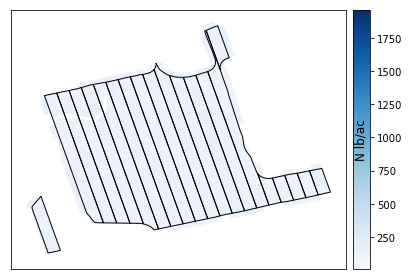

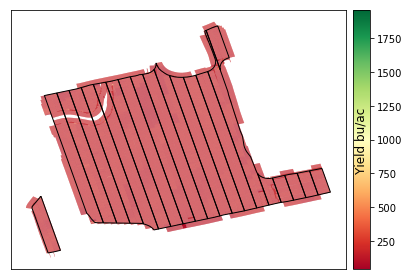

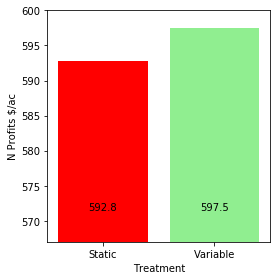

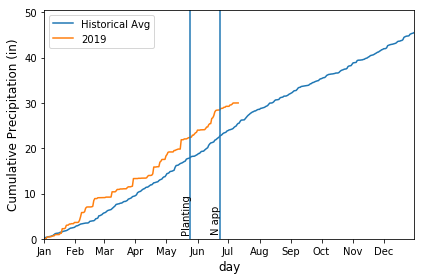

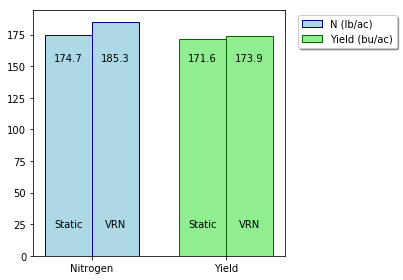

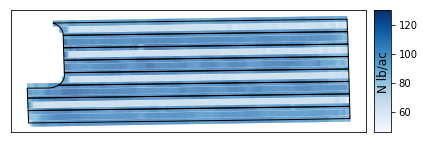

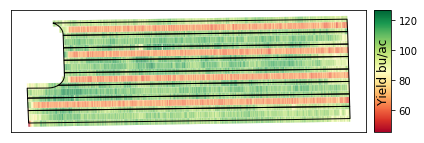

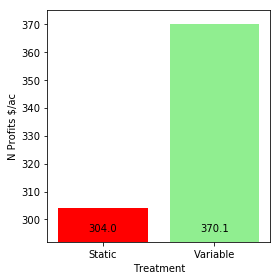

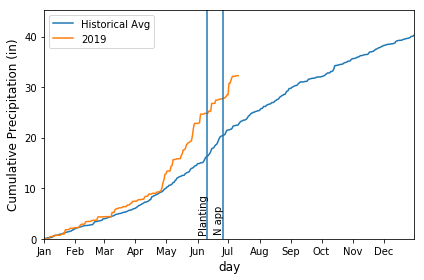

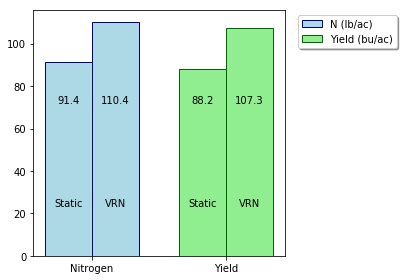

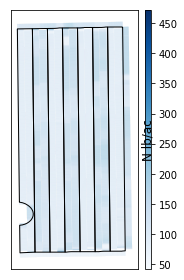

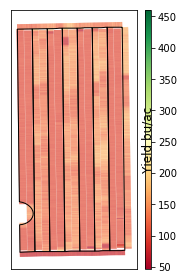

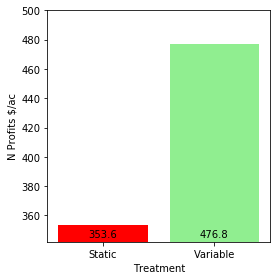

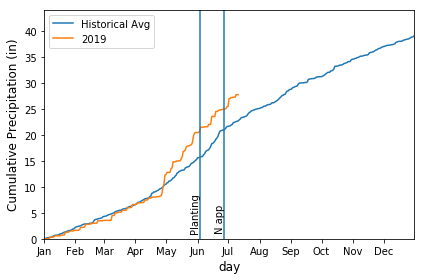

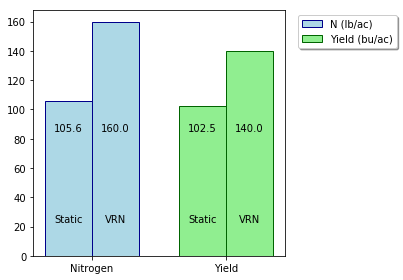

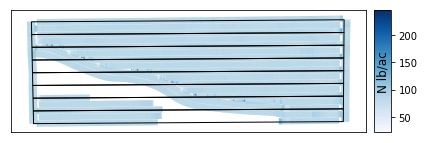

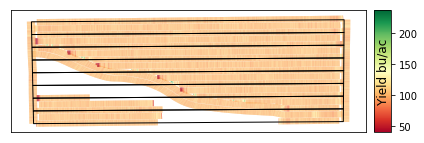

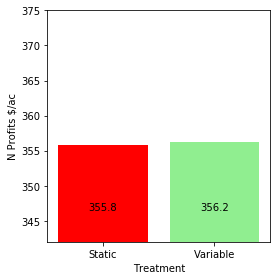

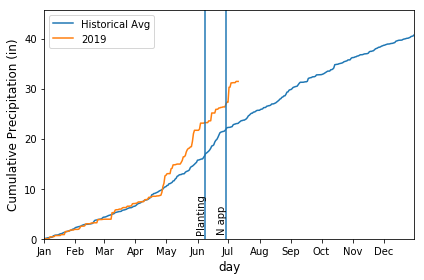

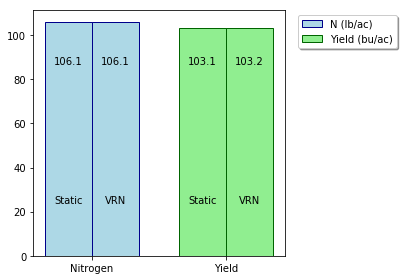

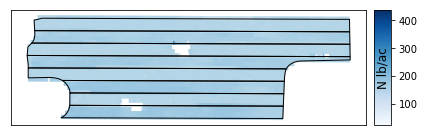

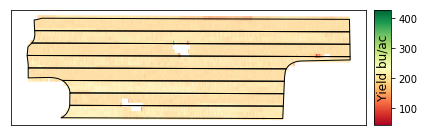

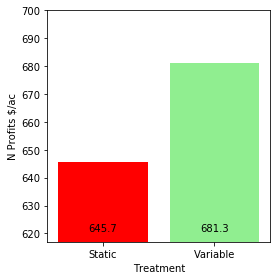

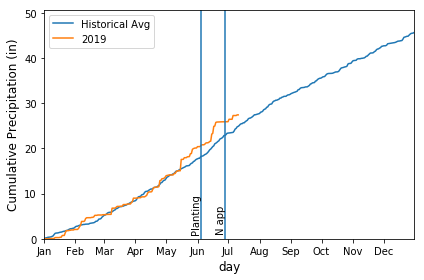

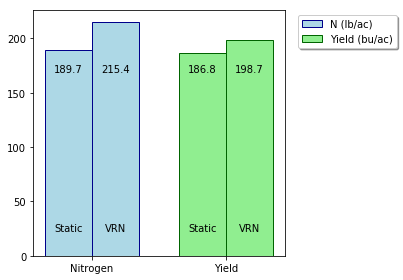

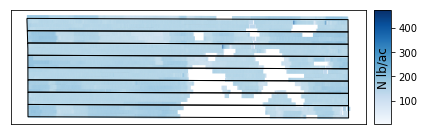

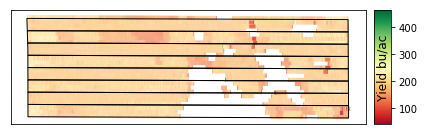

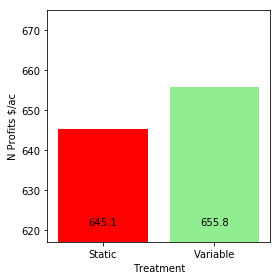

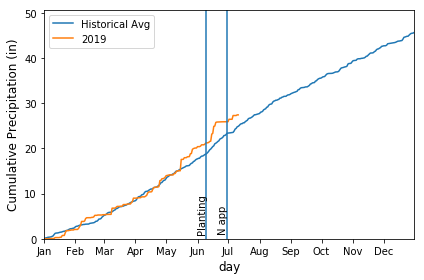

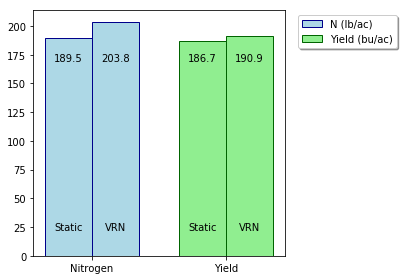

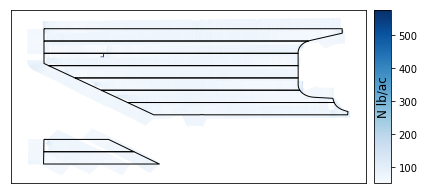

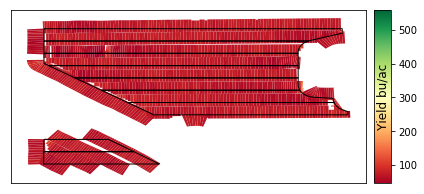

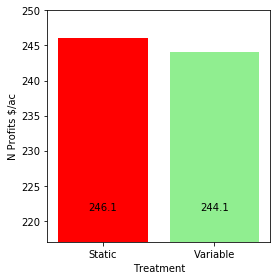

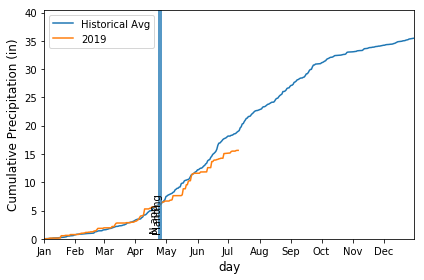

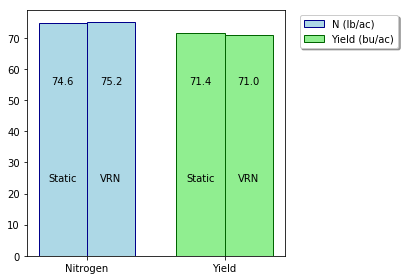

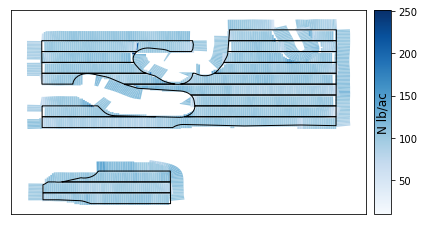

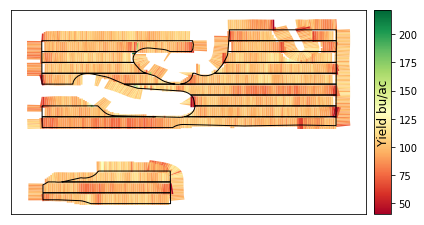

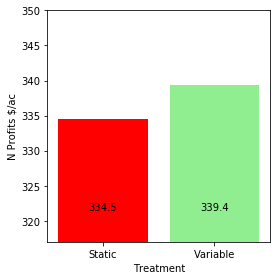

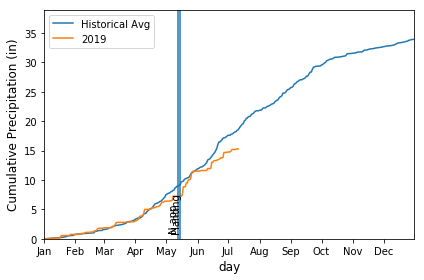

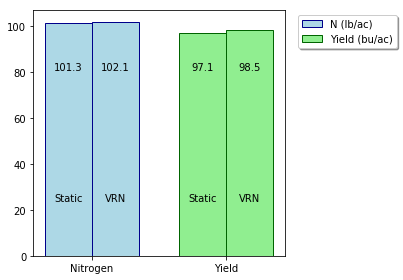

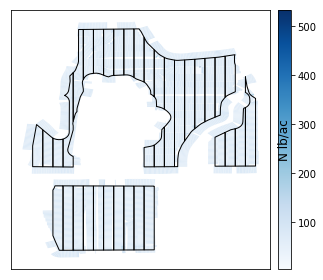

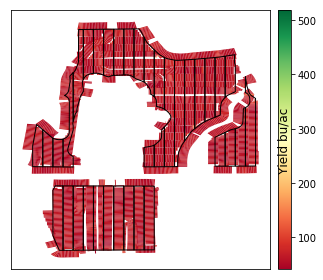

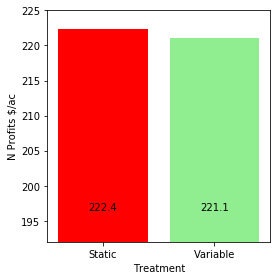

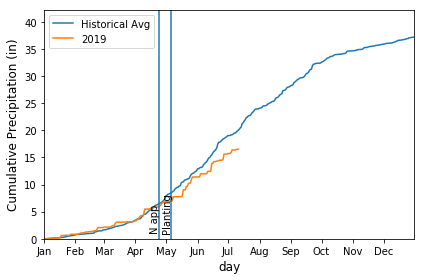

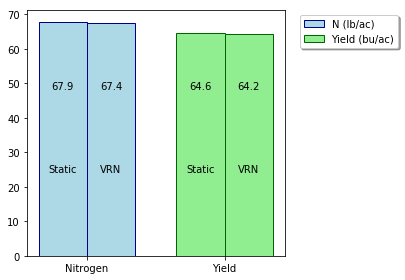

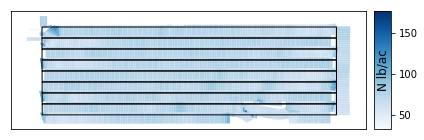

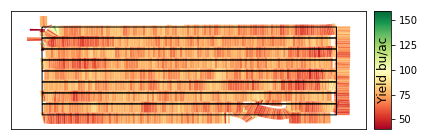

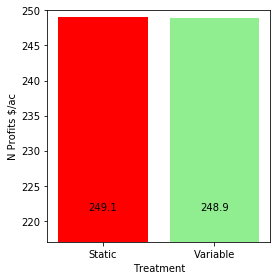

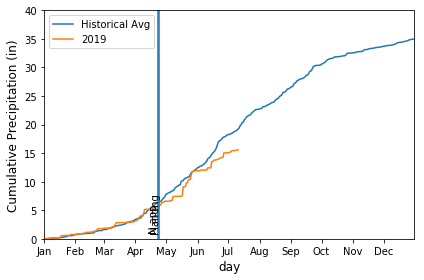

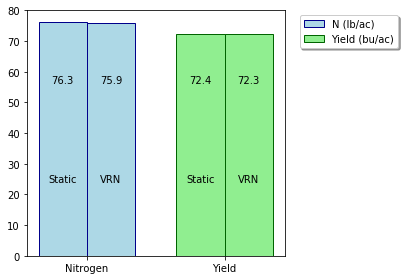

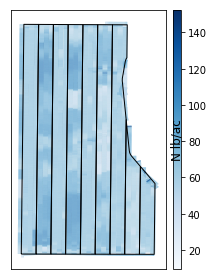

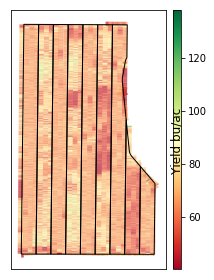

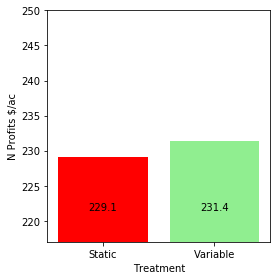

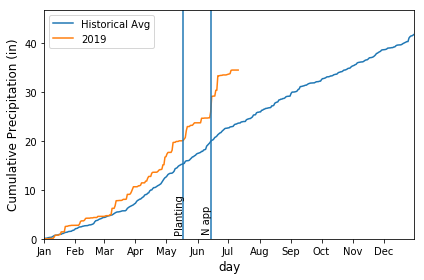

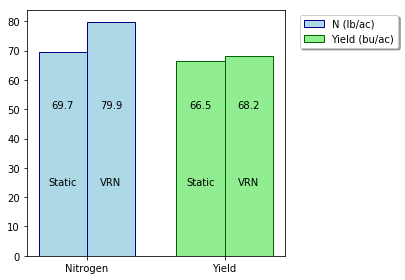

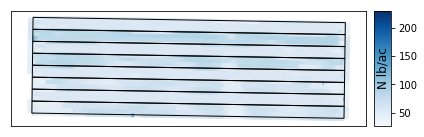

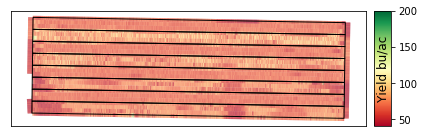

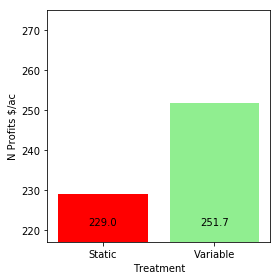

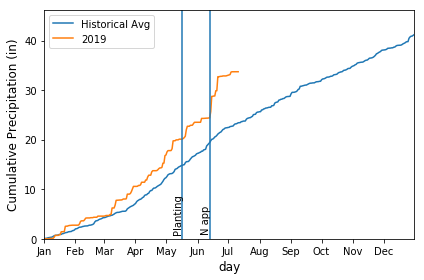

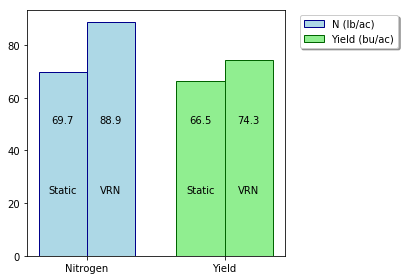

In [25]:
for i in range(0, len(script_ids[['field_id', 'field_legacy_id', 'rx_id']])):
    field_id_n = script_ids[['field_id', 'field_legacy_id', 'rx_id']].iloc[i]
    field_id = field_id_n['field_id']
    pid = 'RTP_'+field_id.upper().replace('-','')+'_C_US_SPR_2019'
    rx_id = field_id_n['rx_id']
    field_legacy_id = field_id_n['field_legacy_id']
    path_to_script = 'teams/fertility/automated-experiments/2019/{}/{}.json'.format(field_legacy_id, rx_id)
    path_to_n_app = s3_modules.glob_s3('/science/FR-Org/2019/2019_Research_Partners/{}/Inputs/Applied/raw_liquid_nitrogen*.csv'.format(pid))
    path_to_planting_data = '/science/FR-Org/2019/2019_Research_Partners/{0}/Analysis/{0}_10x20_Planting_BaseGrid_2019.csv'.format(pid)
    #using 2018 for now
    path_to_yaf = '/science/FR-Org/2018/2018_Climate_Research_Farms/CIL_101G/Analysis/harvest_analysis/CIL_101G_YAF_2018.csv'
    try:
        script_json = s3_modules.json_from_s3(path_to_script, bucket='com.climate.production.users')
        n_app_data = s3_modules.csv_from_s3(path_to_n_app)
        planting_data = s3_modules.csv_from_s3(path_to_planting_data)
        # yaf_data = s3_modules.csv_from_s3(path_to_yaf)
    except Exception as e:
        print(e) 
    else:
        script_gdf = make_script_gdf(script_json)
        n_app_gdf = make_n_app_gdf(n_app_data, script_gdf)
        yaf_gdf = make_fake_yaf_gdf(n_app_gdf) #THIS SHOULD BE REPLACED WITH THE REAL YAF
        make_n_app_map(n_app_gdf)
        make_yield_map(yaf_gdf)
        summary = aggregate_data(script_gdf, n_app_gdf, yaf_gdf, Pc, Pn)
        make_profits_bar(summary)
        save_information_to_json(field_id_n, summary)
        make_weather_plot(script_gdf)
        make_yield_bar(summary)
        print(field_id)
        
    
    